---
title: "Spotify Project"
subtitle: ""
author: "Oleg Ryzhkov (oryzhkov@chicagobooth.edu)"
date: February 12, 2021
output: 
    csv_file: 
---

### Popularity Ranking
* The goal is to build a model for prediction of popularity ranking

In [1]:
# install.packages("textcat")  

In [2]:
library(textcat)

In [4]:
# Load relevant libraries 
library(Boruta)
library(caret)
library(randomForest)
library(mlbench)
library(tidyverse)
library(hrbrthemes)
library(ggplot2)
library(grid)
library(gridExtra)

In [6]:
library(dplyr)
library(glmnet)
library(ROCR)
library(tree)
library(ranger)
library(xgboost)
library(rpart)
library(rpart.plot)
library(corrplot)
library(stringr)  
library(lubridate)

* Functions

In [7]:
# Set plot display parameters 
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
# Calculate RMSE
rmse = function(predict, output){
  sqrt(mean((predict - output)^2))
}
draw_corr <- function(df, cols, sort_col, threshold) {
  
  all_num_values <- df[, cols]
  cor_mtx <- cor(all_num_values, use="pairwise.complete.obs")
  
  cor_sorted <- as.matrix(sort(cor_mtx[, sort_col], decreasing = TRUE))
  
  cor_threshold <- names(which(apply(cor_sorted, 1, function(x) abs(x)>threshold)))
  cor_mtx <- cor_mtx[cor_threshold, cor_threshold]
  corrplot.mixed(cor_mtx, tl.col="black", tl.pos = "lt")
}

* LOAD DATA

In [8]:
# Load the artists data
artist.data<-read.csv('../data/data_by_artist.csv')
artists.rank <- cbind(artists = artist.data$artists, popularity = artist.data$popularity, track_count = artist.data$count)
summary(artists.rank)

   artists           popularity        track_count       
 Length:32539       Length:32539       Length:32539      
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  

In [9]:
artists.rank_df <- as.data.frame(artists.rank) 
column.names.to.integer <- c('popularity', 'track_count')
artists.rank_df <- mutate_at(artists.rank_df, column.names.to.integer, as.integer)
str(artists.rank_df)

'data.frame':	32539 obs. of  3 variables:
 $ artists    : chr  "\"Cats\" 1981 Original London Cast" "\"Cats\" 1983 Broadway Cast" "\"Fiddler On The Roof” Motion Picture Chorus" "\"Fiddler On The Roof” Motion Picture Orchestra" ...
 $ popularity : int  38 31 34 34 42 33 0 3 32 0 ...
 $ track_count: int  10 26 7 27 7 24 2 2 106 2 ...


In [10]:
top_artists <- artists.rank_df[order(artists.rank_df$track_count, decreasing = TRUE),]
head(top_artists)
#artists.rank_df[artists.rank_df$track_count>900,]

,artists,popularity,track_count
,<chr>,<int>,<int>
9762,Francisco Canaro,0,3179
27355,Tadeusz Dolega Mostowicz,0,2562
32375,Эрнест Хемингуэй,0,2350
32374,Эрих Мария Ремарк,0,2124
9833,Frank Sinatra,28,1435
12376,Ignacio Corsini,0,1248


In [11]:
# Load the data
data<-read.csv('../data/data.csv')
str(data)

'data.frame':	174389 obs. of  19 variables:
 $ acousticness    : num  0.991 0.643 0.993 0.000173 0.295 0.996 0.992 0.996 0.996 0.00682 ...
 $ artists         : chr  "['Mamie Smith']" "[\"Screamin' Jay Hawkins\"]" "['Mamie Smith']" "['Oscar Velazquez']" ...
 $ danceability    : num  0.598 0.852 0.647 0.73 0.704 0.424 0.782 0.474 0.469 0.571 ...
 $ duration_ms     : int  168333 150200 163827 422087 165224 198627 195200 186173 146840 476304 ...
 $ energy          : num  0.224 0.517 0.186 0.798 0.707 0.245 0.0573 0.239 0.238 0.753 ...
 $ explicit        : int  0 0 0 0 1 0 0 0 0 0 ...
 $ id              : chr  "0cS0A1fUEUd1EW3FcF8AEI" "0hbkKFIJm7Z05H8Zl9w30f" "11m7laMUgmOKqI3oYzuhne" "19Lc5SfJJ5O1oaxY0fpwfh" ...
 $ instrumentalness: num  5.22e-04 2.64e-02 1.76e-05 8.01e-01 2.46e-04 7.99e-01 1.61e-06 1.86e-01 9.60e-01 8.73e-01 ...
 $ key             : int  5 5 0 2 10 5 5 9 8 8 ...
 $ liveness        : num  0.379 0.0809 0.519 0.128 0.402 0.235 0.176 0.195 0.149 0.092 ...
 $ loudness        : 

In [12]:
# The following tells us the number of missing values in each column.
sapply(data, function(x) sum(is.na(x)))

acousticness          artists     danceability      duration_ms 
               0                0                0                0 
          energy         explicit               id instrumentalness 
               0                0                0                0 
             key         liveness         loudness             mode 
               0                0                0                0 
            name       popularity     release_date      speechiness 
               0                0                0                0 
           tempo          valence             year 
               0                0                0

#### Data Cleaning and Transformation

In [13]:
# vars to delete
var.in<-c("id")
# what I'm keeping
var.out<-setdiff(names(data),var.in)
data_clean <- data[var.out]
data_clean$release_date <- ymd(data_clean$release_date, truncated = 2L)
# cyear <- ymd(data_clean$year, truncated = 2L)
head(data_clean)

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<date>,<dbl>,<dbl>,<dbl>,<int>
1,0.991000,['Mamie Smith'],0.598,168333,0.224,0,5.22e-04,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920-01-01,0.0936,149.976,0.6340,1920
2,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,2.64e-02,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
3,0.993000,['Mamie Smith'],0.647,163827,0.186,0,1.76e-05,0,0.5190,-12.098,1,Golfing Papa,4,1920-01-01,0.1740,97.600,0.6890,1920
4,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,8.01e-01,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomix Remix,17,1920-01-01,0.0425,127.997,0.0422,1920
5,0.295000,['Mixe'],0.704,165224,0.707,1,2.46e-04,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920
6,0.996000,['Mamie Smith & Her Jazz Hounds'],0.424,198627,0.245,0,7.99e-01,5,0.2350,-11.470,1,Crazy Blues - 78rpm Version,9,1920-01-01,0.0397,103.870,0.4770,1920


In [14]:
# (trans <- bc$x[which.max(bc$y)])
# [1] 0.4242424
# # re-run with transformation
# mnew <- lm(((y^trans-1)/trans) ~ x) # Instead of mnew <- lm(y^trans ~ x) 

#### Features Engineering

In [15]:
data_clean$log_popularity <- log(data_clean$popularity+1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00   25.00   25.69   42.00  100.00 

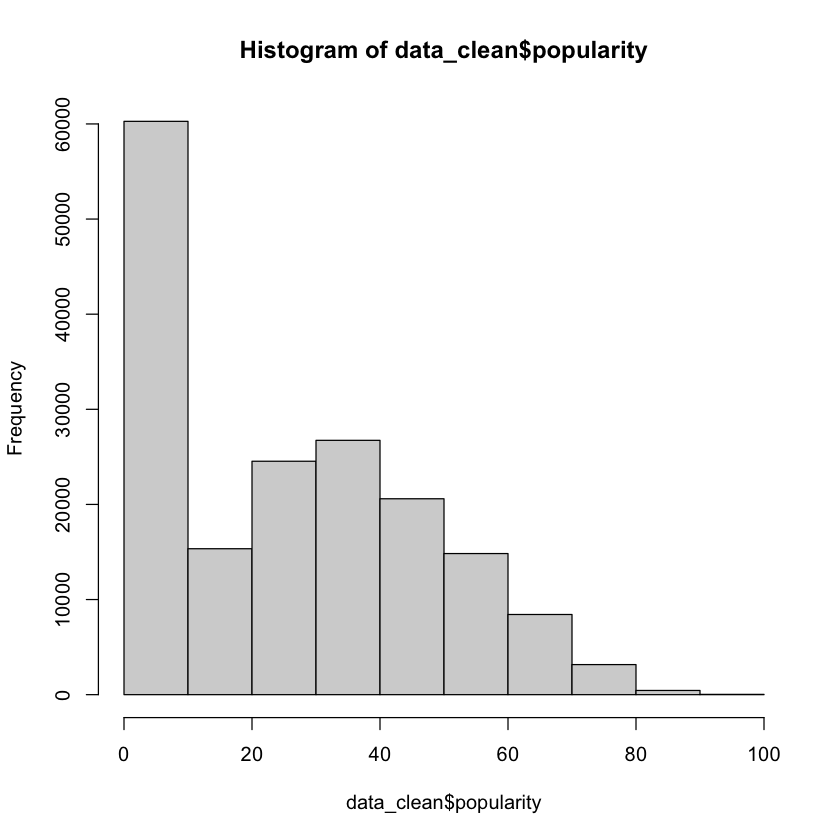

In [16]:
hist(data_clean$popularity,breaks = 12)
summary(data_clean$popularity)

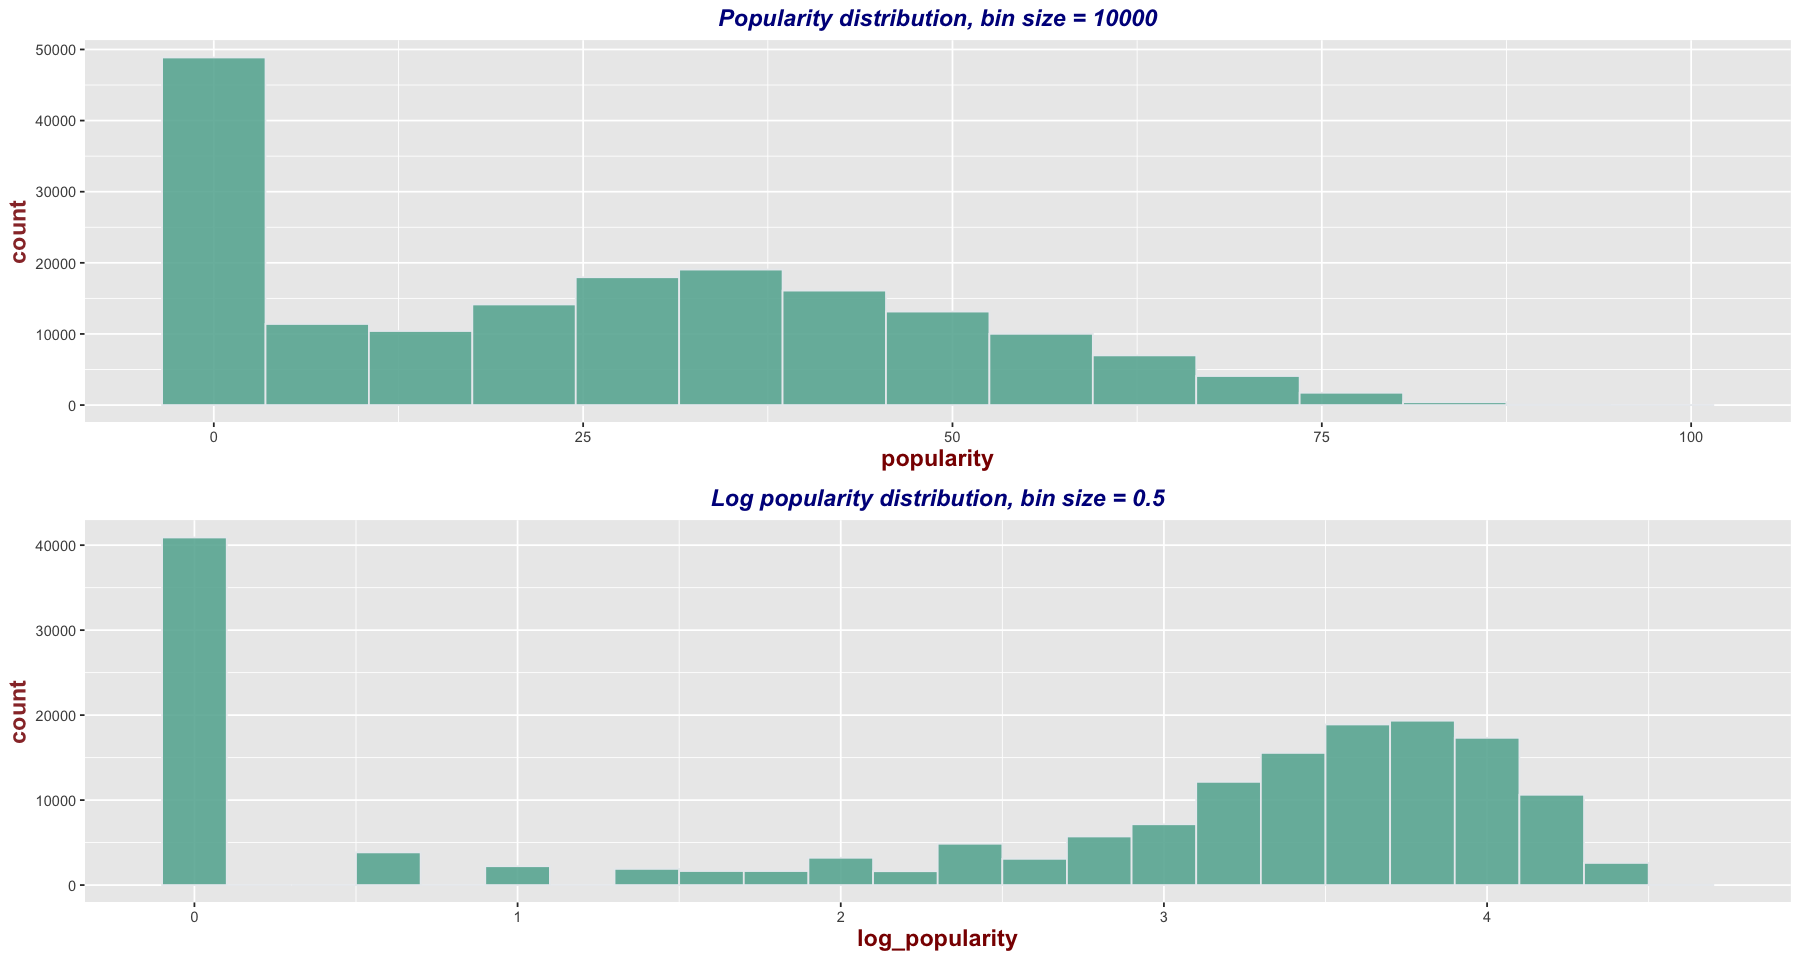

In [17]:
# Histograms
fig(15,8)
hist <- ggplot( data_clean, aes(x=popularity)) +
            geom_histogram( binwidth=7, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
            ggtitle("Popularity distribution, bin size = 10000")+
            theme(
            plot.title = element_text(color="darkblue", size=14, face="bold.italic", hjust=0.5),
            axis.title.x = element_text(color="darkred", size=14, face="bold"),
            axis.title.y = element_text(color="#993333", size=14, face="bold"))
hist_log <- ggplot( data_clean, aes(x=log_popularity)) +
            geom_histogram( binwidth=0.2, fill="#69b3a2", color="#e9ecef", alpha=0.9) +
            ggtitle("Log popularity distribution, bin size = 0.5")+
            theme(
            plot.title = element_text(color="darkblue", size=14, face="bold.italic", hjust=0.5),
            axis.title.x = element_text(color="darkred", size=14, face="bold"),
            axis.title.y = element_text(color="#993333", size=14, face="bold"))
grid.arrange(hist, hist_log, nrow = 2)

In [18]:
#data_clean[,poprank:=factor(popularity>42,labels=c("not popular","popular"))]
data_clean <- data_clean %>% 
                      mutate(poprank = case_when(
                        between(popularity, 70, 100) ~ "very popular",
                        between(popularity, 42, 69) ~ "popular",
                        between(popularity, 1, 41) ~ "low_popularity",
                        between(popularity, 0, 0) ~ "zero_popularity",
                        TRUE ~ NA_character_
                      ))
head(data_clean)

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,log_popularity,poprank
,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<date>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
1,0.991000,['Mamie Smith'],0.598,168333,0.224,0,5.22e-04,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920-01-01,0.0936,149.976,0.6340,1920,2.564949,low_popularity
2,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,2.64e-02,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920,2.079442,low_popularity
3,0.993000,['Mamie Smith'],0.647,163827,0.186,0,1.76e-05,0,0.5190,-12.098,1,Golfing Papa,4,1920-01-01,0.1740,97.600,0.6890,1920,1.609438,low_popularity
4,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,8.01e-01,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomix Remix,17,1920-01-01,0.0425,127.997,0.0422,1920,2.890372,low_popularity
5,0.295000,['Mixe'],0.704,165224,0.707,1,2.46e-04,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920,1.098612,low_popularity
6,0.996000,['Mamie Smith & Her Jazz Hounds'],0.424,198627,0.245,0,7.99e-01,5,0.2350,-11.470,1,Crazy Blues - 78rpm Version,9,1920-01-01,0.0397,103.870,0.4770,1920,2.302585,low_popularity


In [19]:
data_clean$poprank <- as.factor(data_clean$poprank)

In [20]:
summary(data_clean$poprank)

low_popularity         popular    very popular zero_popularity 
          88325           40932            4227           40905

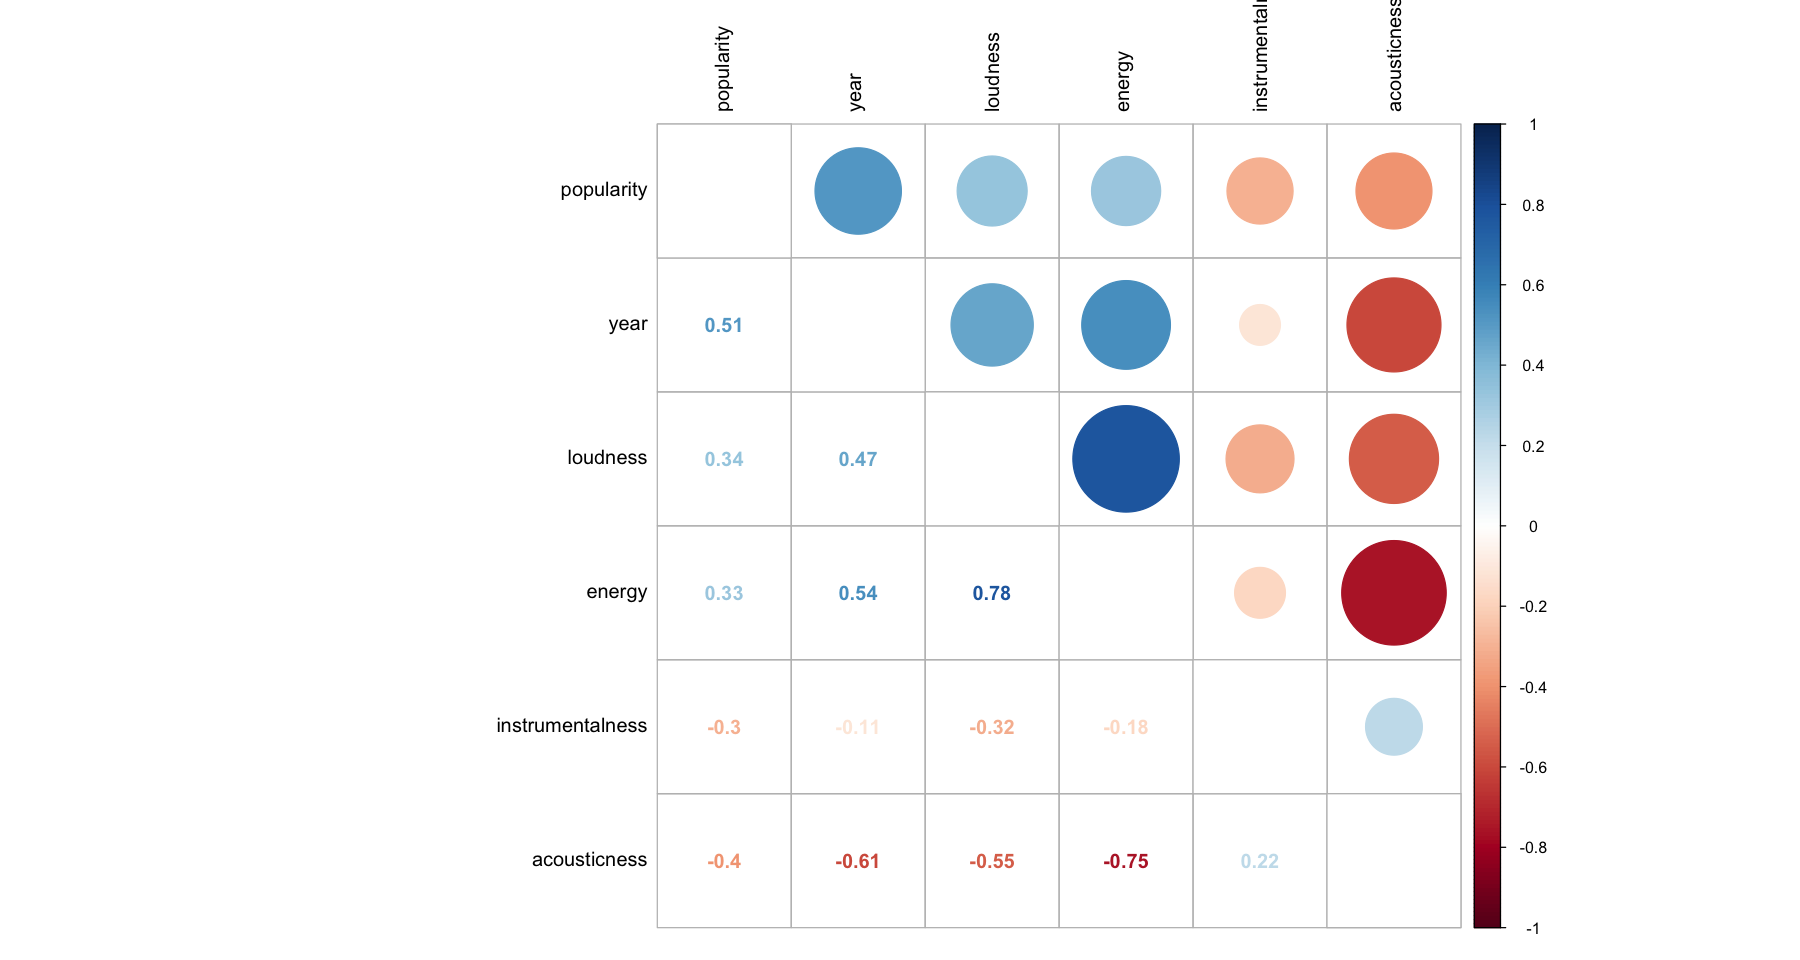

In [21]:
# features_cols <- c('valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'popularity')

features_cols <- c('valence','year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo')

draw_corr(data_clean, features_cols, "popularity", 0.2)

In [22]:
data_clean$language <- as.factor(textcat(data_clean$name))
str(data_clean$language)

 Factor w/ 56 levels "afrikaans","albanian",..: 24 24 53 36 11 8 32 24 50 14 ...


In [32]:
# Summary dataframe
language_sum <- data_clean %>%
    group_by(language, poprank) %>% summarise(n = n()) %>% mutate(freq = round(n / sum(n)*100,2))
language_sum

`summarise()` regrouping output by 'language' (override with `.groups` argument)



language,poprank,n,freq
<fct>,<fct>,<int>,<dbl>
afrikaans,low_popularity,541,58.74
afrikaans,popular,268,29.10
afrikaans,very popular,23,2.50
afrikaans,zero_popularity,89,9.66
albanian,low_popularity,142,52.59
albanian,popular,71,26.30
albanian,very popular,12,4.44
albanian,zero_popularity,45,16.67
basque,low_popularity,879,38.40


In [147]:
# Summary dataframe
language_sum <- data_clean %>%
    group_by(language) %>% mutate(rankmean = round(mean(popularity),2))
head(language_sum)

acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,⋯,popularity,release_date,speechiness,tempo,valence,year,log_popularity,poprank,language,rankmean
<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<date>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<fct>,<fct>,<dbl>
0.991000,['Mamie Smith'],0.598,168333,0.224,0,5.22e-04,5,0.3790,-12.628,⋯,12,1920-01-01,0.0936,149.976,0.6340,1920,2.564949,low_popularity,indonesian,19.29
0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,2.64e-02,5,0.0809,-7.261,⋯,7,1920-01-05,0.0534,86.889,0.9500,1920,2.079442,low_popularity,indonesian,19.29
0.993000,['Mamie Smith'],0.647,163827,0.186,0,1.76e-05,0,0.5190,-12.098,⋯,4,1920-01-01,0.1740,97.600,0.6890,1920,1.609438,low_popularity,tagalog,23.83
0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,8.01e-01,2,0.1280,-7.311,⋯,17,1920-01-01,0.0425,127.997,0.0422,1920,2.890372,low_popularity,portuguese,19.17
0.295000,['Mixe'],0.704,165224,0.707,1,2.46e-04,10,0.4020,-6.036,⋯,2,1920-10-01,0.0768,122.076,0.2990,1920,1.098612,low_popularity,danish,28.13
0.996000,['Mamie Smith & Her Jazz Hounds'],0.424,198627,0.245,0,7.99e-01,5,0.2350,-11.470,⋯,9,1920-01-01,0.0397,103.870,0.4770,1920,2.302585,low_popularity,catalan,27.00


In [149]:
select_columns <- c('language', 'rankmean')
language_sum <- language_sum[, select_columns]
head(language_sum)

language,rankmean
<fct>,<dbl>
indonesian,19.29
indonesian,19.29
tagalog,23.83
portuguese,19.17
danish,28.13
catalan,27.00


In [152]:
lang_sum <- aggregate(language_sum, by=list(lang=language_sum$language), mean)
lang_sum[order(-lang_sum$rankmean),-2]
# colnames(language_sum)

Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(X[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.defaul

,lang,rankmean
,<fct>,<dbl>
33,nepali,41.28
21,hebrew-iso8859_8,36.82
56,welsh,33.83
31,manx,32.77
4,belarus-windows1251,32.43
10,czech-iso8859_2,32.39
22,hungarian,31.68
55,ukrainian-koi8_r,31.45
1,afrikaans,31.34


In [ ]:
plot(data_clean$language)

In [33]:
language.df <- as.data.frame(table(data_clean$language))
language.df <- language.df[order(-language.df$Freq),]
head(language.df)

,Var1,Freq
,<fct>,<int>
13,english,32057
32,middle_frisian,17949
19,german,15635
8,catalan,12849
43,scots,9969
11,danish,5875


In [34]:
# colnames(data_clean)[which(names(data_clean) == "langauge")] <- "language"
data_eng <- data_clean[(data_clean$language== 'english') | (data_clean$language== 'french'),]
str(data_eng)

'data.frame':	37706 obs. of  21 variables:
 $ acousticness    : num  9.84e-01 3.81e-01 9.96e-01 3.97e-03 7.90e-01 9.86e-01 1.75e-05 3.67e-01 9.96e-01 9.89e-01 ...
 $ artists         : chr  "['Dick Haymes']" "['ST']" "['Maurice Chevalier']" "['Ron van der Kraan']" ...
 $ danceability    : num  0.269 0.936 0.613 0.641 0.745 0.641 0.49 0.716 0.679 0.623 ...
 $ duration_ms     : int  181200 166113 178133 257667 261013 179160 454776 264240 175200 180467 ...
 $ energy          : num  0.255 0.372 0.274 0.292 0.791 0.169 0.922 0.836 0.182 0.339 ...
 $ explicit        : int  0 1 0 0 0 0 0 0 0 0 ...
 $ instrumentalness: num  2.63e-03 0.00 4.28e-01 1.21e-04 0.00 0.00 8.55e-01 5.81e-06 6.68e-01 0.00 ...
 $ key             : int  0 0 8 8 7 7 1 9 10 7 ...
 $ liveness        : num  0.178 0.083 0.172 0.356 0.102 0.0706 0.123 0.191 0.47 0.155 ...
 $ loudness        : num  -9.04 -11.63 -14.88 -22.97 -8.58 ...
 $ mode            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ name            : chr  "Serenade of the Be

In [35]:
head(data_eng)

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,⋯,name,popularity,release_date,speechiness,tempo,valence,year,log_popularity,poprank,language
,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,⋯,<chr>,<int>,<date>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<fct>,<fct>
28,0.98400,['Dick Haymes'],0.269,181200,0.255,0,0.002630,0,0.1780,-9.041,⋯,Serenade of the Bells,0,1920-01-01,0.0536,79.186,0.154,1920,0.0000000,zero_popularity,english
29,0.38100,['ST'],0.936,166113,0.372,1,0.000000,0,0.0830,-11.634,⋯,Comme à l'époque,0,1920-01-01,0.4550,133.047,0.222,1920,0.0000000,zero_popularity,french
33,0.99600,['Maurice Chevalier'],0.613,178133,0.274,0,0.428000,8,0.1720,-14.884,⋯,Oh Maurice,0,1920-01-01,0.2250,64.750,0.769,1920,0.0000000,zero_popularity,french
36,0.00397,['Ron van der Kraan'],0.641,257667,0.292,0,0.000121,8,0.3560,-22.969,⋯,Dancehall Good To Me,1,1920-01-03,0.0571,179.967,0.752,1920,0.6931472,low_popularity,english
37,0.79000,"[""The Swingin' Bachelors""]",0.745,261013,0.791,0,0.000000,7,0.1020,-8.584,⋯,Penticton Kitty,0,1920-02-29,0.0595,120.169,0.658,1920,0.0000000,zero_popularity,english
42,0.98600,['Esther Lekain'],0.641,179160,0.169,0,0.000000,7,0.0706,-13.139,⋯,Ca N'vaut Pas L'amour,0,1920-01-01,0.1300,116.249,0.687,1920,0.0000000,zero_popularity,french


In [ ]:
# Change the color of the bars
# ggplot(data_eng, aes(x = language), fill = mode) +
#     geom_bar() +
#     theme(
#             plot.title = element_text(color="darkblue", size=14, face="bold.italic", hjust=0.5),
#             axis.title.x = element_text(color="darkred", size=14, face="bold"),
#             axis.title.y = element_text(color="#993333", size=14, face="bold"))

In [71]:
# Create artists list with rating track count
artists <- data_clean$artists
nrow <- length(artists)
artist.list <- c()
artist.number <- c()
for(i in 1:nrow) {
    list.full <- artists[i]
    list.split <- strsplit(list.full,split=',', fixed=TRUE)[[1]]
    artist.onesong <- c()
    for (j in 1:length(list.split)) {
        value <- str_replace_all(list.split[j], "[^[:alnum:]]", "")    # Delete non-alphanumeric
        list.split[j] = gsub("([a-z])([A-Z])", "\\1 \\2", value)
        artist.onesong <- c(artist.onesong, list.split[j])
        }
    artist.number <- c(artist.number, length(artist.onesong))
    for (artist in artist.onesong) {
            if (is.element(artist, artist.list)) {} else {
        artist.list <- c(artist.list, artist)}
                                }
    }

In [72]:
str(artist.list)
str(artist.number)

 chr [1:32634] "Mamie Smith" "Screamin Jay Hawkins" "Oscar Velazquez" ...
 int [1:174389] 1 1 1 1 1 1 1 1 1 1 ...


In [102]:
artist.df <- as.data.frame(artist.list)
artist.df$artist.rank_sum = 0
artist.df$artist.rank_mean = 0
artist.df$artist.trackcount = 0 
artist.df$artist.trackrankedcount = 0 
head(artist.df)

,artist.list,artist.rank_sum,artist.rank_mean,artist.trackcount,artist.trackrankedcount
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Mamie Smith,0,0,0,0
2,Screamin Jay Hawkins,0,0,0,0
3,Oscar Velazquez,0,0,0,0
4,Mixe,0,0,0,0
5,Mamie Smith Her Jazz Hounds,0,0,0,0
6,Francisco Canaro,0,0,0,0


In [103]:
popularity_rank <- data_clean$popularity
for(i in 1:nrow) {
    list.full <- artists[i]
    list.split <- strsplit(list.full,split=',', fixed=TRUE)[[1]]
    artist.onesong <- c()
    for (j in 1:length(list.split)) {
        value <- str_replace_all(list.split[j], "[^[:alnum:]]", "")    # Delete non-alphanumeric
        list.split[j] = gsub("([a-z])([A-Z])", "\\1 \\2", value)
        artist.onesong <- c(artist.onesong, list.split[j])
        }
    rank = popularity_rank[i]
    for (artist in artist.onesong) {
            if (rank>0) {
            artist.df[artist.df$artist.list==artist,]$artist.rank_sum <- artist.df[artist.df$artist.list==artist,]$artist.rank_sum + rank
            artist.df[artist.df$artist.list==artist,]$artist.trackrankedcount <- artist.df[artist.df$artist.list==artist,]$artist.trackrankedcount + 1    
            }
            artist.df[artist.df$artist.list==artist,]$artist.trackcount <- artist.df[artist.df$artist.list==artist,]$artist.trackcount + 1
    }
}

In [124]:
artist.df$artist.rank_mean = round(artist.df$artist.rank_sum/artist.df$artist.trackrankedcount,2)
artist.df <- artist.df[order(-artist.df$artist.rank_mean),]
head(artist.df[artist.df$artist.trackcount>1,])

,artist.list,artist.rank_sum,artist.rank_mean,artist.trackcount,artist.trackrankedcount
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
19759,Camilo,349,87.25,6,4
16867,Jay Wheeler,172,86.00,2,2
16868,DJNelson,172,86.00,2,2
6066,Tones And I,171,85.50,2,2
6231,HVME,169,84.50,2,2
10300,Regard,168,84.00,2,2


In [153]:
artist.trackrankedcount.df <- artist.df %>%
    group_by(artist.trackrankedcount) %>% summarise(n = n())

`summarise()` ungrouping output (override with `.groups` argument)



In [122]:
summary(artist.df)

 artist.list        artist.rank_sum artist.rank_mean artist.trackcount 
 Length:32634       Min.   :    0   Min.   : 1.00    Min.   :   1.000  
 Class :character   1st Qu.:    0   1st Qu.:16.26    1st Qu.:   1.000  
 Mode  :character   Median :   36   Median :35.50    Median :   2.000  
                    Mean   :  170   Mean   :33.94    Mean   :   7.222  
                    3rd Qu.:   98   3rd Qu.:49.22    3rd Qu.:   4.000  
                    Max.   :22115   Max.   :94.00    Max.   :2228.000  
                                    NA's   :8744                       
 artist.trackrankedcount
 Min.   :  0.000        
 1st Qu.:  0.000        
 Median :  1.000        
 Mean   :  5.253        
 3rd Qu.:  3.000        
 Max.   :773.000        
                        

In [200]:
artist.trackcount <- c()
artist.ranksum <- c()
artist.trackrankedcount <- c()
artist.rankmean <- c()
for(i in 1:nrow) {
    list.full <- artists[i]
    list.split <- strsplit(list.full,split=',', fixed=TRUE)[[1]]
    artist.onesong <- c()
    for (j in 1:length(list.split)) {
        value <- str_replace_all(list.split[j], "[^[:alnum:]]", "")    # Delete non-alphanumeric
        list.split[j] = gsub("([a-z])([A-Z])", "\\1 \\2", value)
        artist.onesong <- c(artist.onesong, list.split[j])
        }
    rank_sum = 0
    trackrankedcount = 0
    trackcount = 0
    for (artist in artist.onesong) {
           
            rank_sum = rank_sum + artist.df[artist.df$artist.list==artist,]$artist.rank_sum 
            trackrankedcount = trackrankedcount + artist.df[artist.df$artist.list==artist,]$artist.trackrankedcount     
            trackcount = trackcount + artist.df[artist.df$artist.list==artist,]$artist.trackcount
    }
    artist.ranksum <- c(artist.ranksum, rank_sum)
    artist.trackcount <- c(artist.trackcount, trackcount)
    artist.trackrankedcount <- c(artist.trackrankedcount, trackrankedcount)
    
}

In [193]:
artists[200]

[1] "['Dick Haymes', 'Helen Forrest']"

In [194]:
str(artist.number)

[1] 2

In [201]:
str(artist.ranksum)

 num [1:174389] 28 311 28 33 2 10 28 10 112 0 ...


In [196]:
artist.trackcount[200]

[1] NA

In [197]:
artist.trackrankedcount[200]

[1] NA

In [212]:
artist.df[artist.df$artist.list=='Dick Haymes',]

,artist.list,artist.rank_sum,artist.rank_mean,artist.trackcount,artist.trackrankedcount
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
20,Dick Haymes,189,7.27,49,26


In [199]:
artist.df[artist.df$artist.list=='Helen Forrest',]

,artist.list,artist.rank_sum,artist.rank_mean,artist.trackcount,artist.trackrankedcount
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
96,Helen Forrest,189,13.5,18,14


In [223]:
updated_data <- data_clean[,-2]
# Get levels and add "None"
levels <- levels(updated_data$language)
levels[length(levels) + 1] <- "None"

# refactor Species to include "None" as a factor level
# and replace NA with "None"
updated_data$language <- factor(updated_data$language, levels = levels)
updated_data$language[is.na(updated_data$language)] <- "None"

In [224]:
updated_data$name <- as.factor(updated_data$name)
updated_data$language.eng <- ifelse(updated_data$language =='english', 1,0)
updated_data$artist.number <- artist.number
updated_data$artist.rank_sum <- artist.ranksum
updated_data$artist.trackcount <- artist.trackcount
updated_data$artist.trackrankedcount <- artist.trackrankedcount
updated_data$artist.rank_mean = round(updated_data$artist.rank_sum/updated_data$artist.trackrankedcount,2)
str(updated_data)

'data.frame':	174389 obs. of  26 variables:
 $ acousticness           : num  0.991 0.643 0.993 0.000173 0.295 0.996 0.992 0.996 0.996 0.00682 ...
 $ danceability           : num  0.598 0.852 0.647 0.73 0.704 0.424 0.782 0.474 0.469 0.571 ...
 $ duration_ms            : int  168333 150200 163827 422087 165224 198627 195200 186173 146840 476304 ...
 $ energy                 : num  0.224 0.517 0.186 0.798 0.707 0.245 0.0573 0.239 0.238 0.753 ...
 $ explicit               : int  0 0 0 0 1 0 0 0 0 0 ...
 $ instrumentalness       : num  5.22e-04 2.64e-02 1.76e-05 8.01e-01 2.46e-04 7.99e-01 1.61e-06 1.86e-01 9.60e-01 8.73e-01 ...
 $ key                    : int  5 5 0 2 10 5 5 9 8 8 ...
 $ liveness               : num  0.379 0.0809 0.519 0.128 0.402 0.235 0.176 0.195 0.149 0.092 ...
 $ loudness               : num  -12.63 -7.26 -12.1 -7.31 -6.04 ...
 $ mode                   : int  0 0 1 1 0 1 1 1 1 1 ...
 $ name                   : Factor w/ 137013 levels "________","-",..: 60708 51420 42793

In [225]:
summary(updated_data)

  acousticness     danceability     duration_ms          energy      
 Min.   :0.0000   Min.   :0.0000   Min.   :   4937   Min.   :0.0000  
 1st Qu.:0.0877   1st Qu.:0.4140   1st Qu.: 166133   1st Qu.:0.2490  
 Median :0.5170   Median :0.5480   Median : 205787   Median :0.4650  
 Mean   :0.4992   Mean   :0.5368   Mean   : 232810   Mean   :0.4827  
 3rd Qu.:0.8950   3rd Qu.:0.6690   3rd Qu.: 265720   3rd Qu.:0.7110  
 Max.   :0.9960   Max.   :0.9880   Max.   :5338302   Max.   :1.0000  
                                                                     
    explicit       instrumentalness        key            liveness     
 Min.   :0.00000   Min.   :0.000000   Min.   : 0.000   Min.   :0.0000  
 1st Qu.:0.00000   1st Qu.:0.000000   1st Qu.: 2.000   1st Qu.:0.0992  
 Median :0.00000   Median :0.000524   Median : 5.000   Median :0.1380  
 Mean   :0.06814   Mean   :0.197252   Mean   : 5.205   Mean   :0.2111  
 3rd Qu.:0.00000   3rd Qu.:0.252000   3rd Qu.: 8.000   3rd Qu.:0.2700  
 Max.   

In [215]:
write.csv(updated_data,file = "../data/updated_originaldata.csv")

In [39]:
artist.df <- as.data.frame(table(artist.list))
artist.df <- artist.df[order(-artist.df$Freq),]
str(artist.df)
head(artist.df)

'data.frame':	32634 obs. of  2 variables:
 $ artist.list: Factor w/ 32634 levels "","000Maniacs",..: 9839 27543 32471 32470 10050 14122 31663 17677 9918 31449 ...
 $ Freq       : int  2228 1281 1175 1062 1013 936 916 897 773 704 ...


,artist.list,Freq
,<fct>,<int>
9839,Francisco Canaro,2228
27543,Tadeusz Dolega Mostowicz,1281
32471,ЭрнестХемингуэй,1175
32470,ЭрихМарияРемарк,1062
10050,Frédéric Chopin,1013
14122,Johann Sebastian Bach,936


In [40]:
subset <- data_clean[grep("Francisco Canaro", data_clean$artists), ]
str(subset)

'data.frame':	2254 obs. of  21 variables:
 $ acousticness    : num  0.996 0.996 0.996 0.996 0.996 0.996 0.996 0.996 0.996 0.996 ...
 $ artists         : chr  "['Francisco Canaro']" "['Francisco Canaro']" "['Francisco Canaro']" "['Francisco Canaro']" ...
 $ danceability    : num  0.469 0.579 0.468 0.369 0.433 0.37 0.345 0.589 0.477 0.616 ...
 $ duration_ms     : int  146840 167213 177427 168293 148720 155467 156040 185707 154493 170373 ...
 $ energy          : num  0.238 0.356 0.533 0.285 0.322 0.19 0.326 0.185 0.319 0.334 ...
 $ explicit        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ instrumentalness: num  0.96 0.948 0.87 0.938 0.983 0.966 0.953 0.92 0.972 0.946 ...
 $ key             : int  8 10 1 7 9 8 0 1 11 8 ...
 $ liveness        : num  0.149 0.174 0.179 0.193 0.216 0.128 0.197 0.107 0.148 0.203 ...
 $ loudness        : num  -18.7 -14.6 -11 -16.5 -16.1 ...
 $ mode            : int  1 1 1 1 1 1 1 0 0 1 ...
 $ name            : chr  "La Chacarera - Remasterizado" "Desengaño - Remasteriza

In [41]:
# Create artists list with rating track count
nrow <- length(data_clean)
artist.list <- c()
for(i in 1:500) {
    list.full <- artists[i]
    list.split <- strsplit(list.full,split=',', fixed=TRUE)[[1]]
    for (j in 1:length(list.split)) {
        value <- str_replace_all(list.split[j], "[^[:alnum:]]", "")    # Delete non-alphanumeric
        list.split[j] = gsub("([a-z])([A-Z])", "\\1 \\2", value)
        artist.list <- c(artist.list, list.split[j])
    }
}

In [42]:
artist.list[1:20]

[1] "Mamie Smith"                 "Screamin Jay Hawkins"       
 [3] "Mamie Smith"                 "Oscar Velazquez"            
 [5] "Mixe"                        "Mamie Smith Her Jazz Hounds"
 [7] "Mamie Smith"                 "Mamie Smith Her Jazz Hounds"
 [9] "Francisco Canaro"            "Meetya"                     
[11] "Dorville"                    "Francisco Canaro"           
[13] "Ka Koula"                    "Justrock"                   
[15] "Takis Nikolaou"              "Aggeliki Karagianni"        
[17] "Giorgos Katsaros"            "Francisco Canaro"           
[19] "Giorgos Katsaros"            "Amalia Vaka"